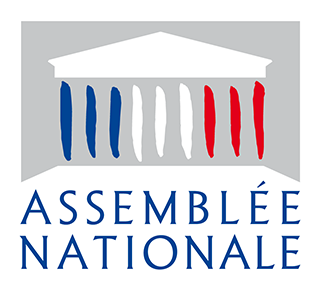

# RAMP on french deputies votes prediction 
### *a.k.a. Deputies watcher* 

*EISENBARTH Florian*, *OULIANOV Nicolas*, *BOUSSENINA Nicolas*, *FOUCAULT Armand*, *ALARDET Eloi*


Link for the Github repository : 

## Introduction

### Context

The National Assembly is the French lower house of the parliament, the higher house being the Senate. It is composed of deputies elected every five years during legislatives elections. One deputy represents one electoral district, composed of 63 000 to 150 000 inhabitants. The French electoral districts are divided as follows: 539 districts in metropolitan France, 27 for overseas French territories (overseas departments included), and 11 for the French citizens living abroad, which makes a total of **577 seats available**. The absolute majority is therefore obtained with 289 seats. 


One deputy is elected under the banner of political party (or not, he can be independent, but it is rare). If he wins the election in his district, he enters the assembly and must make a choice. In fact, the political parties have no meaning inside of the house: we talk of **parliamentary groups**. It must be composed of at least 15 deputies to be formed. Of course, in most of the cases, one political party corresponds to one parliamentary group but sometimes, it can be wider than only one party. Being part of group is really important as it is a condition to some of the legislative aspects: you get more time to talk at the assembly, you have one representative at the president's conference (a weekly reunion of all the parliamentary groups presidents to discuss about the amendments, text of laws that will be debated during the week). If a deputy does not belong to any parliamentary groups, he is part of the **‘non inscrit’** group, which is not a parliamentary group strictly speaking. The case of the 'non-inscrit' is quite hard to analyse since it gathers deputies from various political origins (from left to right wing).


A deputy can also be a member of a **parliamentary commission**, which are specialized groups that review the laws for a specific subject (it exists commissions for finance, security, health…). 


In the French legislative system, the government and deputies can propose laws. Before a law is adopted, we talk of:
+ **project of law**, when it is proposed by the government
+ **proposition of law**, when it is a parliament member text of law

All members of the parliament, commissions and the government can propose **amendments** which are modifications about parts/articles of the discussed text of law. It is basically a rewrite of one particular aspect of the text of law. It also exists **sub-amendments**, which basically deal with amendments ($\Leftrightarrow$ amendment of an amendment).


All text of laws and amendments are voted by absolute majority, with one deputy equals one vote.

### Objective

As one can imagine, the way deputies act is really observed by citizens, and it is normal. You elected someone and want to have some feedbacks on his acts. But since always, one criticism that remains is the fact that politicians (deputies) always have political manners. Basically, the thought is that they will always vote for a project of law proposed by their group and never for another group’s proposal. 

The idea behind this project is to highlight this phenomenon. By analyzing previous votes results, we want to predict the way some political groups react to amendments and text of laws: if they always vote against the government? if they only support their own proposals?

Let's check out these received ideas !

To do so, we use some data which presents the results of the vote which occured at the Assembly. We won't analyse them by deputy, but in order to simplify the problem by parliamentary groups: in majority, will this group vote for or against this amendment. This will give us first results about the political logics hold by our deputies.

In a more technical point of view, after analysing the problem it was decided to represent the problem with a simple output. In fact, if they are too much possible options as outputs, our estimator will have troubles to perfectly fit to the data, and we won't obtain good results as the complexity of the problem would increase. Thus, our **model output is binary** and shows if the party has voted *'for'* the project of law. If it is no, it gathers different choices: *'against', 'abstention'*, or *'non-presence'*.

The results will be evaluated with a **custom metric**: based on f1-score, it will be weighted over the share of a parliamentary group in the assembly.

### Data

All the data we use in this project comes from government's data, freely available on the National Assembly website : https://data.assemblee-nationale.fr/. Downloaded, it looks like a stack of .csv file, one for each tuple. We first created a python script to regroup these csv files onto three different dataframe: 
+ one with all the actors (deputies and their parties)
+ one with all the votes subject (quick presentation of the law, if it is an amendment or the complete project of law, who proposed it) 
+ one with the actual votes (who vote for and against).

Since the composition of the Assembly changes every five years with the elections, it is useless to analyse old votes of other decades: we focused on the ones of this legislature. The first analysed vote therefore took place on July, 4th 2017, and the last one on November, 20th 2020 ; which makes a total of 3244 votes.

To create our final dataset, we implemented **problem.py** . In this script, we create create an object of the class Vote for each vote that happened at the Assembly. By calling the methods `get_train_data()` and `get_test_data()`, it returns the data formated as a dataframe: basically, one vote is equivalent to one tuple in the dataframe.


## Access the data

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import problem

X_df, y = problem.get_train_data()  # get_test_data() brings you the test dataset

### Features

We used the following **features** for our problem:
 + **id (str)**: the id of the vote
 + **code_type_vote (str)**:  code of the type of the vote
 + **libelle_type_vote (str)**: type of the vote
 + **demandeur (str)** : the deputy or group which has asked for this vote
 + **libelle (str)**: the object of the vote
 + **nb_votants (int)**: total number of deputies who actually voted
 + **date (str)**: date of the vote
 + **presence_per_party (dic)**: number of deputies physically present for the vote by party
 + **vote_uid (str)**: id of the vote
 
Our **output** corresponds to the results of the vote: **1.** ($\Leftrightarrow$ for) or **0.** ($\Leftrightarrow$ other choice :includes *against, abstention, non-presence*) **by parliamentary group**, formated as a dataframe with the **id** of the vote as index. It **presents the opinion of the majority of each parliamentary group**.


In [4]:
X_df.head()

,code_type_vote,libelle_type_vote,demandeur,libelle,nb_votants,date,presence_per_party,vote_uid
VTANR5L15V1,SPS,scrutin public solennel,Conference des Presidents,la declaration de politique generale du Gouver...,566,2017-07-04,"{'SOC': 22, 'FI': 17, 'Dem': 51, 'LT': 17, 'GD...",VTANR5L15V1
VTANR5L15V2,SPO,scrutin public ordinaire,"President(e) du groupe ""La Republique en Marche""",l'ensemble du projet de loi prorogeant l'appli...,150,2017-07-06,"{'SOC': 3, 'FI': 11, 'Dem': 9, 'LT': 1, 'GDR':...",VTANR5L15V2
VTANR5L15V3,SPO,scrutin public ordinaire,"President du groupe ""Nouvelle Gauche""",la motion de renvoi en commission deposee par ...,225,2017-07-10,"{'SOC': 4, 'FI': 15, 'Dem': 15, 'LT': 4, 'GDR'...",VTANR5L15V3
VTANR5L15V4,SPO,scrutin public ordinaire,"President(e) du groupe ""de la Gauche democrate...",l'amendement n? 13 de M. Gilbert Collard et le...,202,2017-07-10,"{'SOC': 0, 'FI': 15, 'Dem': 11, 'LT': 4, 'GDR'...",VTANR5L15V4
VTANR5L15V5,SPO,scrutin public ordinaire,"Président du groupe ""Nouvelle Gauche""",l'amendement n° 132 de M. Prud'homme et les am...,182,2017-07-10,"{'SOC': 4, 'FI': 14, 'Dem': 9, 'LT': 2, 'GDR':...",VTANR5L15V5


In [5]:
y.head()

,SOC,FI,Dem,LT,GDR,LaREM,Agir ens,UDI-I,LR,NI
VTANR5L15V1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
VTANR5L15V2,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
VTANR5L15V3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
VTANR5L15V4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
VTANR5L15V5,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


## Graphics and stats about the data

In [2]:
import create_dataset
from create_dataset import normalize_txt
acteurs, votes, scrutins = create_dataset.load_data()
acteurs.shape

(541, 11)

Let us study some statistics about each party before jumping onto the different votes.

In [8]:
effectif_table = acteurs[["membre_acteurRef", 'membre_parti']].groupby("membre_parti").count().reset_index().rename({"membre_parti": "parti", "membre_acteurRef": "parti_nb_membres"}, axis=1).set_index('parti')
effectif_table

,parti_nb_membres
parti,
Calédonie Ensemble,2
Cap sur l'avenir,1
Debout la France,3
Europe Écologie Les Verts,1
La France Insoumise,17
La République en Marche,287
Les Républicains,91
Mouvement Démocrate,53
Non déclaré(s),1


Indeed "LREM" and "Mouvement démocrate" are being part of the majority in the assembly. On the other hand, some parties only have 1 deputie.

We now want to see the distribution of the ages and the share of women in each party.

In [9]:
parite_table = pd.pivot_table(acteurs, values="membre_acteurRef", columns="membre_sex", index="membre_parti", aggfunc='count', fill_value=0).reset_index().rename({"membre_parti": "parti"}, axis=1).set_index('parti')
parite_table["parti_share_women"] = parite_table["F"] / (parite_table["F"] + parite_table["H"])
parite_table.drop(["F", "H"], axis=1, inplace=True)

membre_sex,parti_share_women
parti,
Calédonie Ensemble,0.000000
Cap sur l'avenir,0.000000
Debout la France,0.333333
Europe Écologie Les Verts,1.000000
La France Insoumise,0.411765
La République en Marche,0.484321
Les Républicains,0.230769
Mouvement Démocrate,0.339623
Non déclaré(s),0.000000


In [10]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def yearsago(years, from_date=None):
    if from_date is None:
        from_date = datetime.now()
    return from_date - relativedelta(years=years)

def num_years(begin, end=None):
    if end is None:
        end = datetime.now()
    num_years = int((end - begin).days / 365.25)
    if begin > yearsago(num_years, end):
        return num_years - 1
    else:
        return num_years

acteurs['membre_birthDate'] = pd.to_datetime(acteurs['membre_birthDate'])
acteurs["membre_age"] = acteurs["membre_birthDate"].apply(num_years)
age_table = acteurs[["membre_acteurRef", 'membre_parti', "membre_age"]].groupby("membre_parti").mean().reset_index().rename({"membre_parti": "parti", "membre_age": "parti_mean_age"}, axis=1).set_index('parti')
age_table

,parti_mean_age
parti,
Calédonie Ensemble,57.000000
Cap sur l'avenir,56.000000
Debout la France,63.333333
Europe Écologie Les Verts,47.000000
La France Insoumise,46.705882
La République en Marche,49.327526
Les Républicains,55.901099
Mouvement Démocrate,55.547170
Non déclaré(s),55.000000


Text(0, 0.5, 'Mean age')

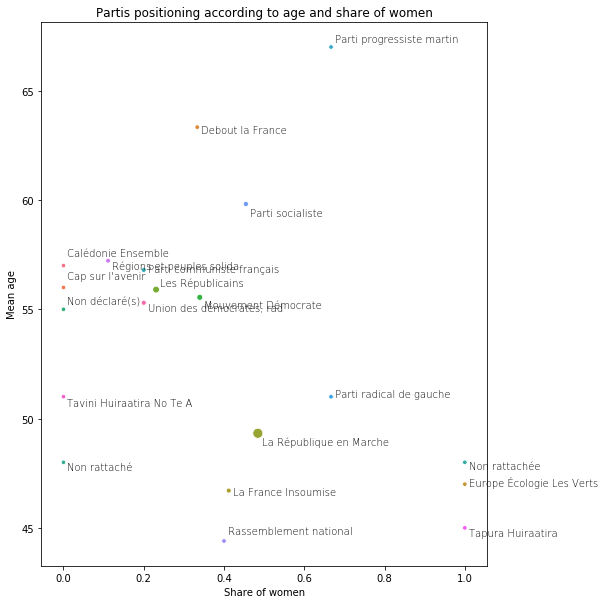

In [13]:
parti_features = effectif_table.join(parite_table).join(age_table)
plt.figure(figsize=(8,10))
p1 = sns.scatterplot(x='parti_share_women', y='parti_mean_age', data=parti_features.reset_index(), size = "parti_nb_membres", hue="parti", legend=False, sizes=(20,100))  

for line in range(0, parti_features.shape[0]):
     p1.text(parti_features['parti_share_women'][line]+0.01, parti_features['parti_mean_age'][line] + 1.2*(0.5 - np.random.random()), 
     parti_features.reset_index()['parti'][line][:25], horizontalalignment='left', 
     size='medium', color='black', weight='light')

plt.title('Partis positioning according to age and share of women')
# Set x-axis label
plt.xlabel('Share of women')
# Set y-axis label
plt.ylabel('Mean age')

From the graph above we can see the mean age per party and the percentage of women per party as well. For the share of women, "Les Républicains" are way behind the other big parties by having only 25% of women when "LREM", "Parti socialiste" and "LFI" have roughly at least 50% of women. Regarding the age of the big parties, "Mouvement démocrate", "Parti socialiste" and "Les Républicains" are the oldest in the assembly. Indeed, it denotes of the traditional left-center-right wings conflicts. In the mean time "LREM" is relatively younger than these traditional parties.

In [3]:
df = scrutins.merge(votes, on='vote_uid')
df.head()

,Unnamed: 0_x,parti,abstention,contre,pour,vote_uid,Unnamed: 0_y,vote_objet,vote_demandeur,vote_date,vote_jourSeance,vote_typeCode,vote_typeName,vote_typeMajorite
0,0,La France Insoumise,0.0,2.0,0.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés
1,1,La République en Marche,3.0,11.0,41.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés
2,2,Les Républicains,0.0,2.0,13.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés
3,3,Mouvement Démocrate,0.0,2.0,6.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés
4,4,Non rattachée,0.0,0.0,1.0,VTANR5L15V2827,0,l'amendement n° 2166 rectifié du Gouvernement ...,"Président du groupe ""UDI et Indépendants""",2020-07-29,1,SPO,scrutin public ordinaire,majorité absolue des suffrages exprimés


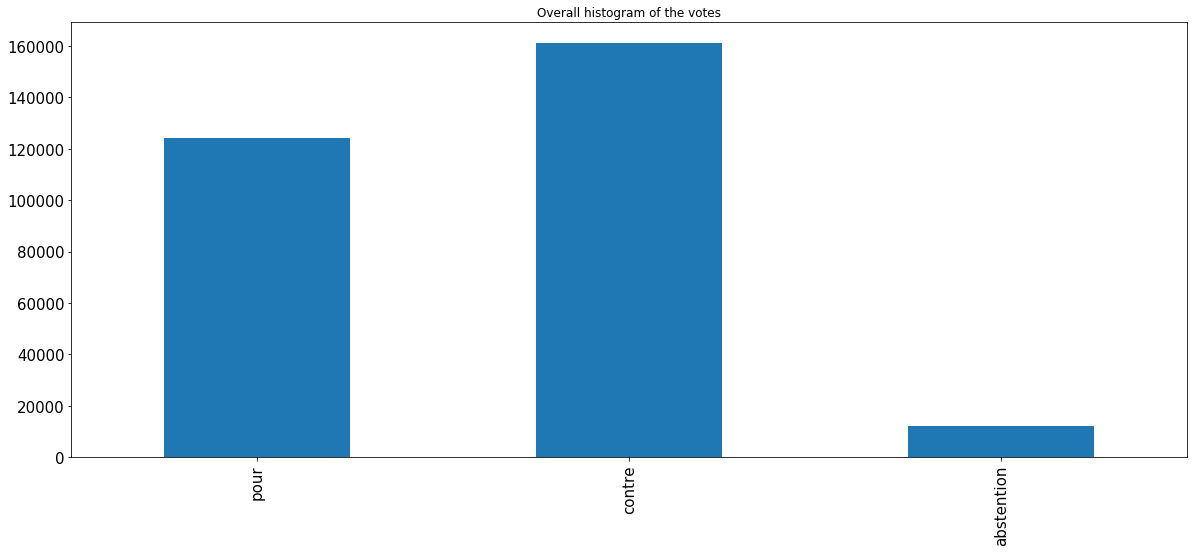

In [4]:
df.groupby("parti")[["pour","contre","abstention"]].sum().sum().plot(kind="bar", figsize=(20,8), title="Overall histogram of the votes", fontsize=15)


In the assembly, most of the votes are against the propositions, does this indicate that the country does not want to move with the majority party "LREM" ? Or maybe that "LREM" does not want its opponents to pass amendments with them so everyone has to decide for the country ? All of this still indicates that the partisan logic is hard and very uncertain.

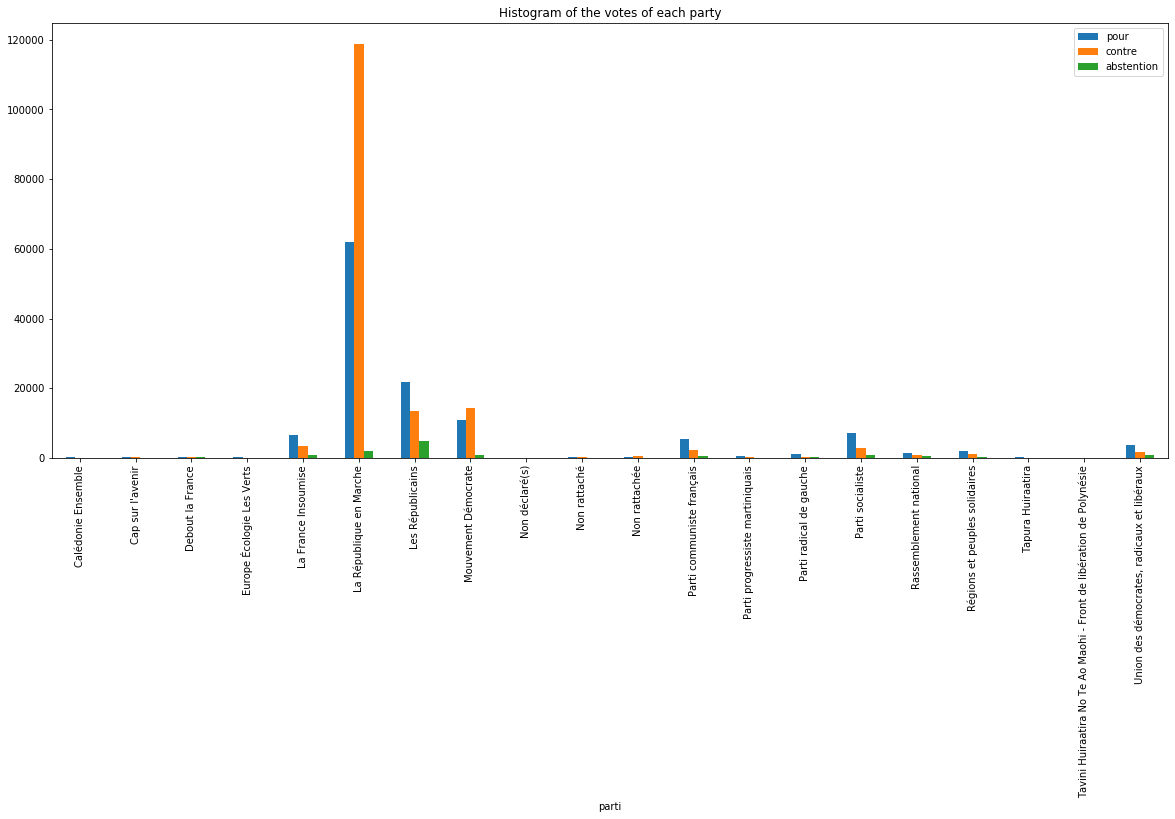

In [5]:
df.groupby("parti")[["pour","contre","abstention"]].sum().plot(kind="bar",figsize=(20,8), title="Histogram of the votes of each party")


We can see that "LREM" is largely voting against any kind of propositions in the assembly. Indeed, as the majority party ("LREM" and "Mouvement Démocrate"), they will only vote for their propositions.

The right wing of the opposition "Les Républicains" vote in the majority in the favor of the assembly's propositions so as the left wing : "La France Insoumise", "Parti communiste Français" and "Parti socialiste". Indeed, the opposition of the majority party will vote what destabilizes the most "LREM".
So even if the right and the left wings are political opponents, they help each other in order to prevent "LREM" to pass their rules.

In [8]:
df.shape

(26386, 14)

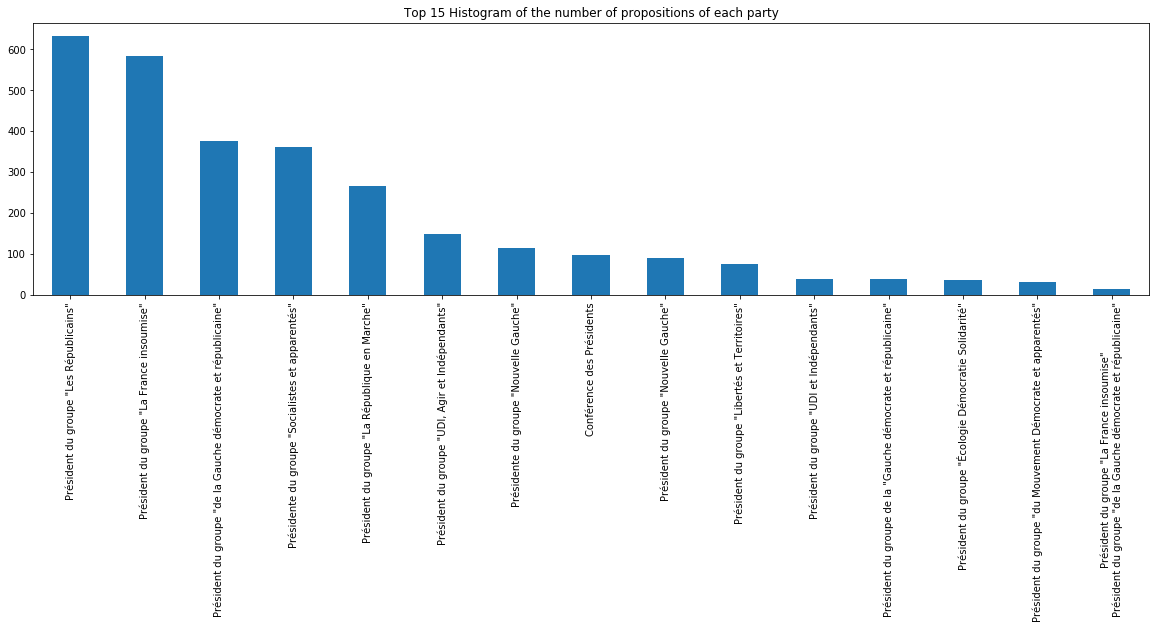

In [6]:

df_grouped = df.groupby(["vote_uid", "vote_demandeur"]).count()
df_grouped.reset_index()['vote_demandeur'].value_counts(ascending=False)[0:15].plot(kind="bar", figsize=(20,5), title="Top 15 Histogram of the number of propositions of each party")

Let's now see who submits the most requests to be voted in the assembly.

The histogram shows that the opposition is submitting the most propositions in the assembly even though they are not as much deputies as LREM. This may point that other parties submit propositions to maybe slow down the process of the vote of laws.

At which cost do the other parties are willing to accept to stop LREM to vote their laws bu submitting amendments ? This is what we are going to study by seeing, for each big groups, who votes what. 

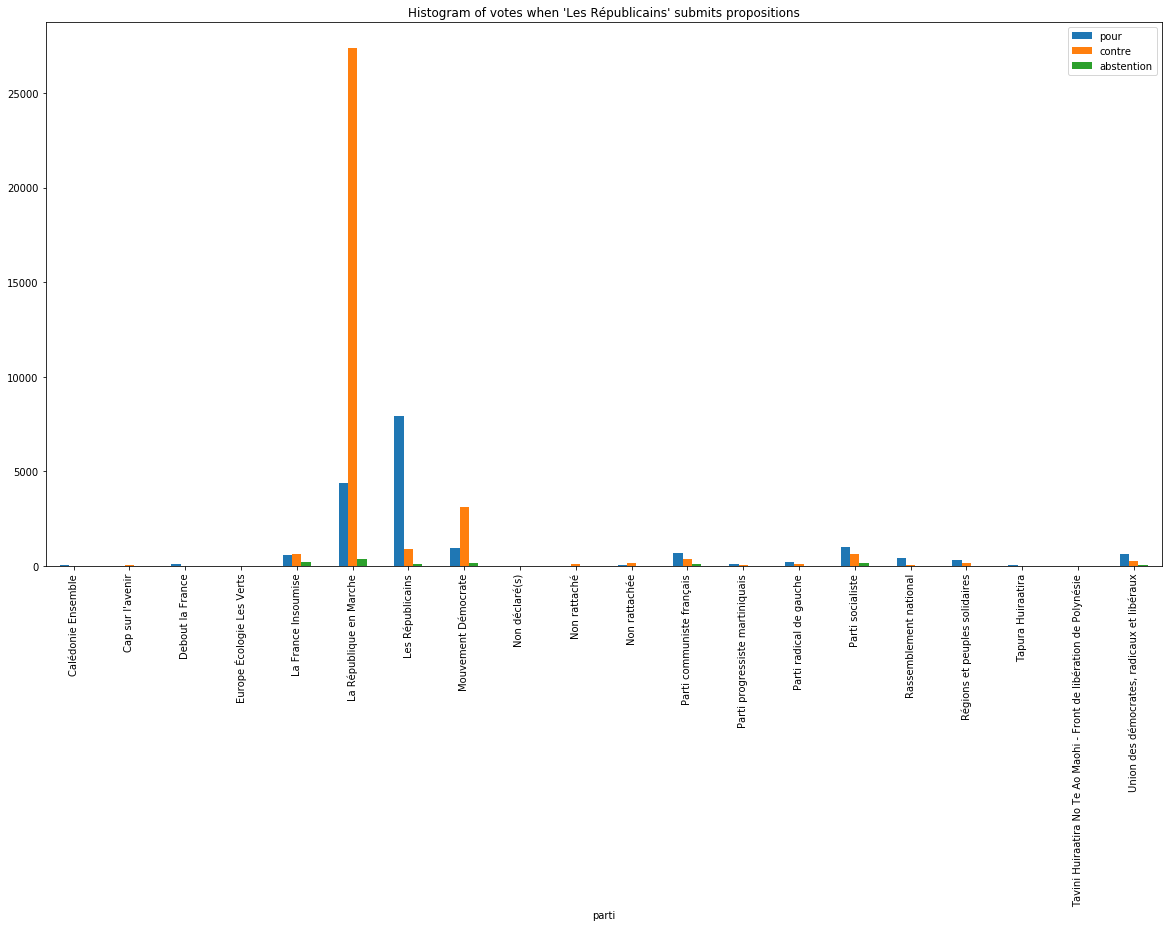

In [7]:
df[df['vote_demandeur'] == 'Président du groupe "Les Républicains"' ].groupby("parti")[["pour","contre","abstention"]].sum().plot(kind="bar",figsize=(20,10), title="Histogram of votes when 'Les Républicains' submits propositions")


What is interesting to see is that obviously "LR" votes in favor of their propositions, so does the left wing ("Parti socialiste", "Parti communiste" etc). So political opponents are still supporting each other when it comes to crush the majority, even if they don't agree on some big principles. Nevertheless, even if "La France Insoumise" is part of the left wing, they still don't acknowledge "LR"'s propositions compared to their allies.

In the opinion, LREM is said to be left wing as right wing, but still massively votes against "LR" propositions. Indeed, we can then question this affirmation.

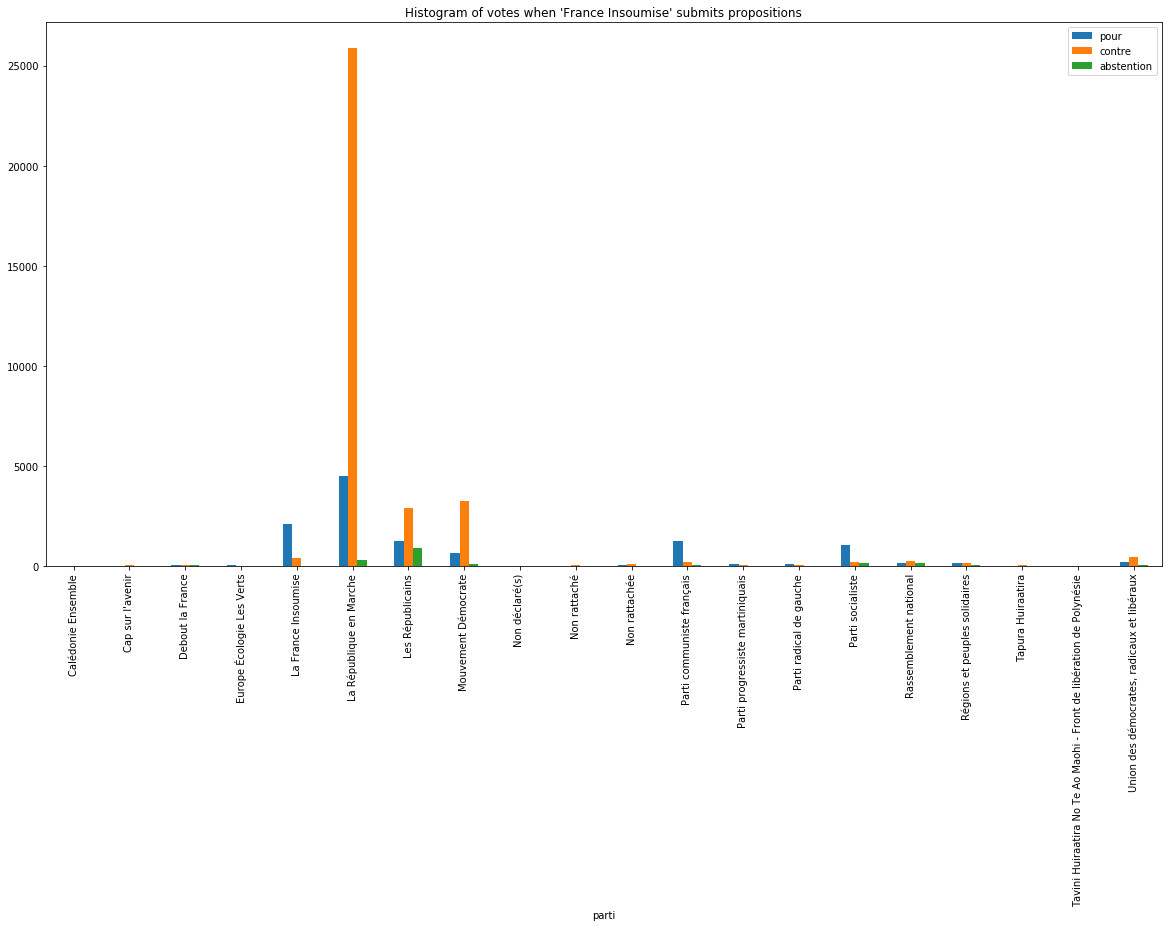

In [45]:
df[df['vote_demandeur'] == 'Président du groupe "La France insoumise"' ].groupby("parti")[["pour","contre","abstention"]].sum().plot(kind="bar",figsize=(20,10), title="Histogram of votes when 'France Insoumise' submits propositions")

As before "LREM" is opposed as well as "LR". Even if opponents help each other, between "LR" and "La France Insoumise" nothing is settled.

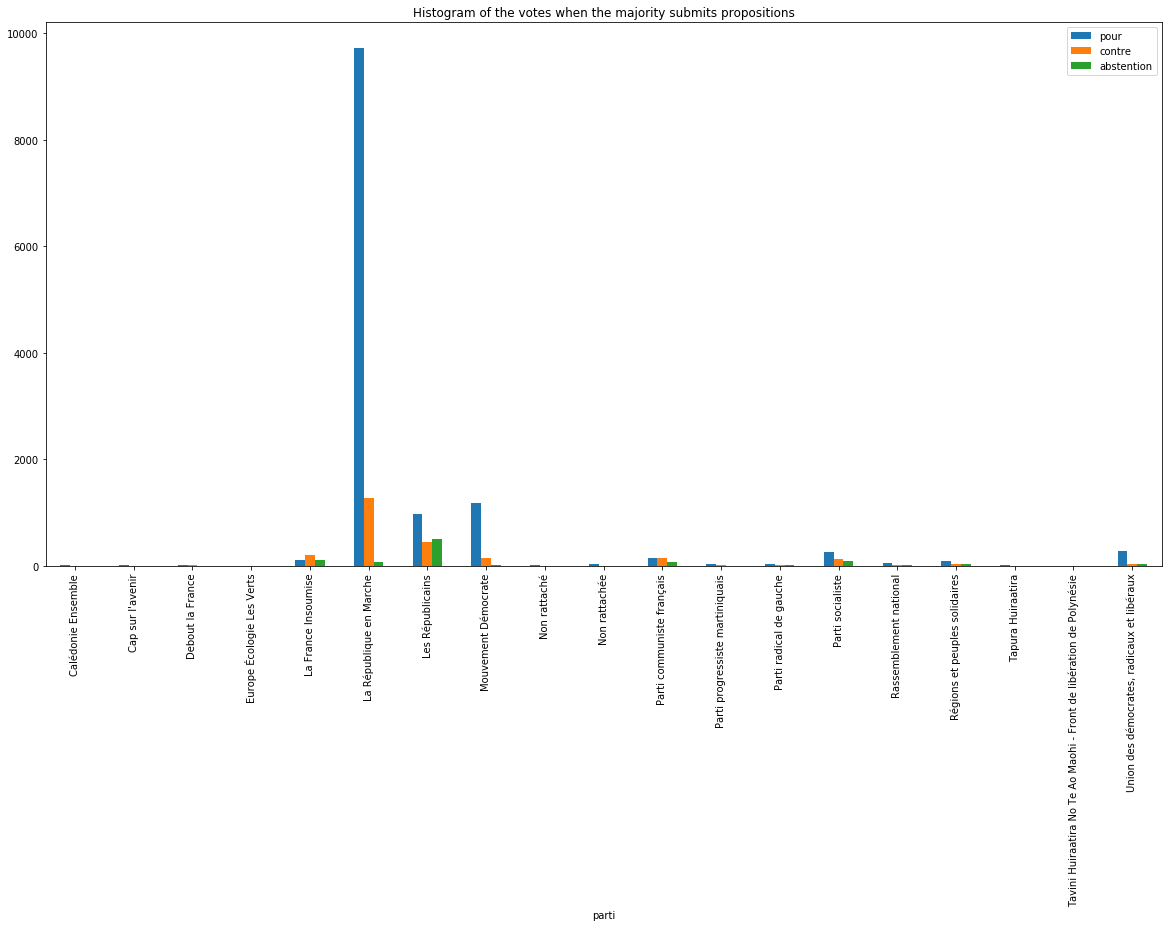

In [46]:
df[df['vote_demandeur'] == 'Président du groupe "La République en Marche"' ].groupby("parti")[["pour","contre","abstention"]].sum().plot(kind="bar",figsize=(20,10), title="Histogram of the votes when the majority submits propositions")

As expected the majority ("LREM" and "Mouvement Démocrate") are voting in favor of the propositions of "LREM". But what is surprising is that "LR" is also in favor of the propositions, when "LREM" is not when is the opposite situation. The same observation is to be made with "Parti socialiste".

## The prediction 

To elaborate the perdictions, we created an estimator.py file that does some transformations on the data received from the problem.py.

### Find the groups that propose a vote
First, we extract the parties that are proposing a vote. There is often more than one group that submits a proposition. By having a look at the dataset, we extracted the different groups. We return a list so we can have multiple parties.

### Decompose the "vote_objet" column
The "vote_objet" column contains 3 main pieces of information :
- What kind of vote has been voted (a law, an amendement ...)
- A short description of the vote
- The authors of the proposition

We wrote 3 functions that we apply to the "vote_objet" column in order to have these information by the use of regex expressions


### Find the party of each author of a proposition
From the previous transformer we had authors for a vote, now we are focusing on finding their party

### The estimator
*Actors*

We fetch some other data about the deputies in order to have some information about them and their parties. We use fill the missing value with a constant field 'unknown'.

*Count vectorizer*

We wanted to make use of the description of the proposition, indeed some words may be left or right wing connoted. To use these words, we first instanciate a CountVectorizer. It counts the occurency of words in a corpus based on a pre-defined vocabulary set. The matrix returned is the size (number of sentences, size of the vocabulary list). The ith element in a line is the count of the occurency of the ith vocabulary word. In our case the vocabulary set if all the words found in the description of the propositions.

*TF-IDF transformer*

We proceed with a TF-IDF transformer on our count vector. Sklearn's doc describes it as follows :
>Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

>The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

*https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html*

We assign some weights to the important words by weighting more the name of a law (*bioéthique* or *sécurité globale* for instance)